# Testing hypotheses

Project description:   
You are an analyst at a big online store. Together with the marketing department, you've compiled a list of hypotheses that may help boost revenue. You need to prioritize these hypotheses, launch an A/B test, and analyze the results.

### Table of Contents <a class="anchor" id="contents"></a>

* [Preparing data for analysis](#chapter1)
    * [HYPOTHESES](#section_1_1)
    * [ORDERS](#section_1_2)
    * [VISITS](#section_1_3)
* [Part 1. Prioritizing Hypotheses](#chapter2)
* [Part 2. A/B Test Analysis](#chapter3)
    * [CUMULATIVE REVENUE BY GROUP](#section_3_1)
    * [CUMULATIVE AVERAGE ORDER SIZE BY GROUP](#section_3_2)
    * [RELATIVE DIFFERENCE IN CUMULATIVE AVERAGE ORDER SIZE BY GROUP](#section_3_3)
    * [CONVERSION BY GROUPS](#section_3_4)
    * [NUMBER OF ORDERS PER USER](#section_3_5)
    * [ORDER PRICES](#section_3_6)
    * [STATISTICAL DIFFERENCE: RAW DATA](#section_3_7)
    * [STATISTICAL DIFFERENCE: FILTERED DATA](#section_3_8)
* [Conclusions](#chapter4)

### Preparing data for analysis <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### <font color='blue'> HYPOTHESES </font> <a class="anchor" id="section_1_1"> </a>

In [2]:
hypotheses = pd.read_csv('hypotheses_us.csv', sep =';')

In [3]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


This table seems fine, I have just separated the columns with ";"

#### ORDERS <a class="anchor" id="section_1_2"></a>

In [4]:
orders = pd.read_csv('orders_us.csv')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


It was mentioned in the task that there are visitors appeared in more than one test group. I will check the data for this issue.

In [6]:
users_by_groups = orders.groupby('visitorId').agg({'group':'nunique'})

In [7]:
print('Number of users who appear in both two groups:',len(users_by_groups[users_by_groups['group'] > 1]))

Number of users who appear in both two groups: 58


So I have found **58** users who appeared in both testing groups. In order to keep the samples clear I will delete these users from the data base.

In [8]:
toomany = users_by_groups[users_by_groups['group'] > 1]

In [9]:
orders = orders[np.logical_not(orders['visitorId'].isin(toomany.index))]

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [11]:
orders['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

#### VISITS <a class="anchor" id="section_1_3"></a>

In [12]:
visits = pd.read_csv('visits_us.csv')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Visits tables seems fine, I just changed the date into datetime type.

[back to contents](#contents)

### Part 1. Prioritizing Hypotheses <a class="anchor" id="chapter2"></a>

In [14]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']).round(2)
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']).round(2)

In [15]:
hypotheses[['Hypothesis', 'ICE', 'RICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE,RICE
8,Launch a promotion that gives users discounts ...,16.20,16.2
0,Add two new channels for attracting traffic. T...,13.33,40.0
7,Add a subscription form to all the main pages....,11.20,112.0
6,Show banners with current offers and sales on ...,8.00,40.0
2,Add product recommendation blocks to the store...,7.00,56.0
1,Launch your own delivery service. This will sh...,2.00,4.0
5,Add a customer review page. This will increase...,1.33,4.0
3,Change the category structure. This will incre...,1.12,9.0
4,Change the background color on the main page. ...,1.00,3.0


**ICE-model** which takes into account impact, confidence and effort shows that there are 3 hypotheses worth trying on: **discounts promotions, two new traffic channels and adding a subsription form to the main page** - all of the are characterized with high level of impact and confidence and medium efforts (I assume they are neither cheap nor expensive to implement).

RICE-model takes into account ICE-parameters and one more - Reach. It adds another important measure - how many users will be affected by the changes. And here is the absolute winner - **subscription form on the main page** - it is obvious that the biggest part of users start (or finish their website journey) with the main page.  
The leader of ICE-model is quite hard to be evaluated from the point of reach: sending out 10000 promotions doesnt mean that it will reach 10000 users, or showing 5000 times ad banner doesnt lead to 5000 users who have actually seen it. So it is almost out of the ranking.

[back to contents](#contents)

### Part 2. A/B Test Analysis <a class="anchor" id="chapter2"></a>

#### CUMULATIVE REVENUE BY GROUP <a class="anchor" id="section_3_1"></a>

In [16]:
groups_by_dates = orders[['date', 'group']].drop_duplicates()

In [17]:
orders_agg = groups_by_dates.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date':'max',
    'group':'max',
    'transactionId':pd.Series.nunique,
    'visitorId':pd.Series.nunique,
    'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [18]:
orders_agg.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [19]:
visits_agg = groups_by_dates.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({
    'date':'max',
    'group':'max',
    'visits':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [20]:
visits_agg.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [21]:
cumulative = orders_agg.merge(visits_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative.columns = ['date', 'group', 'n_orders', 'n_buyers', 'total_revenue', 'n_visits']
cumulative.head()

,date,group,n_orders,n_buyers,total_revenue,n_visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


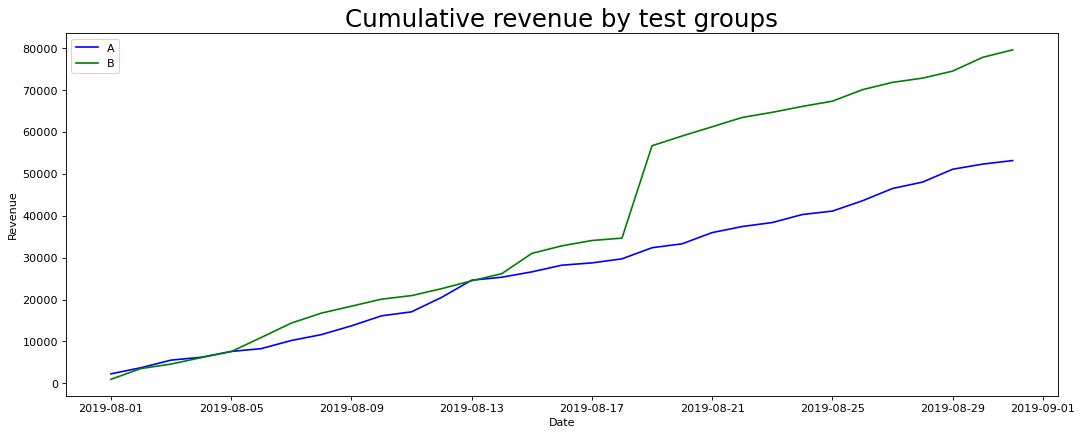

In [22]:
cumulative_revenueA = cumulative[cumulative['group']=='A'][['date', 'total_revenue', 'n_orders']]
cumulative_revenueB = cumulative[cumulative['group']=='B'][['date', 'total_revenue', 'n_orders']]

plt.figure(figsize=(16,6), dpi= 80)
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['total_revenue'], label='A', color='blue')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['total_revenue'], label='B', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title("Cumulative revenue by test groups", fontsize=22)
plt.show()

From the very first glance **group B gives better results than group A** as soon as their total revenue is higher. Especially after some event happened on 18-19th of August which led to drastic rise of revenue and kept on the high level. This event could spoil the whole test, so it needs further investigation.

[back to contents](#contents)

#### CUMULATIVE AVERAGE ORDER SIZE BY GROUP <a class="anchor" id="section_3_2"></a>

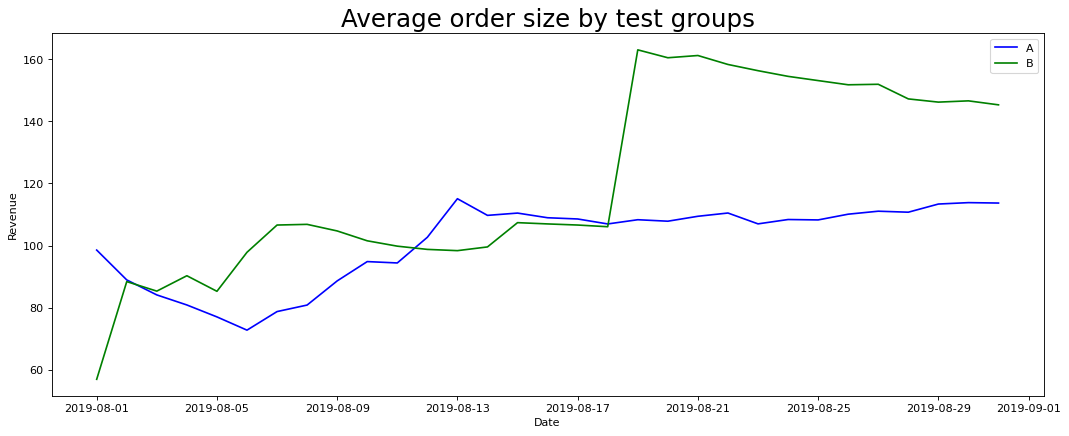

In [23]:
plt.figure(figsize=(16,6), dpi= 80)
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['total_revenue']/cumulative_revenueA['n_orders'], label='A', color='blue')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['total_revenue']/cumulative_revenueB['n_orders'], label='B', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title("Average order size by test groups", fontsize=22)
plt.show()

**Group B** had better results at the begining of the test and then again that signigicant rise. It either demonstrates that test led to fantastic results and rise in revenues or there happened some event which spoilt everything.

[back to contents](#contents)

#### RELATIVE DIFFERENCE IN CUMULATIVE AVERAGE ORDER SIZE BY GROUP <a class="anchor" id="section_3_3"></a>

In [24]:
cum_revenue = cumulative_revenueA.merge(cumulative_revenueB,
                                        left_on='date', right_on='date',
                                        how='left', suffixes=['A', 'B'])

In [25]:
cum_revenue.head()

,date,total_revenueA,n_ordersA,total_revenueB,n_ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


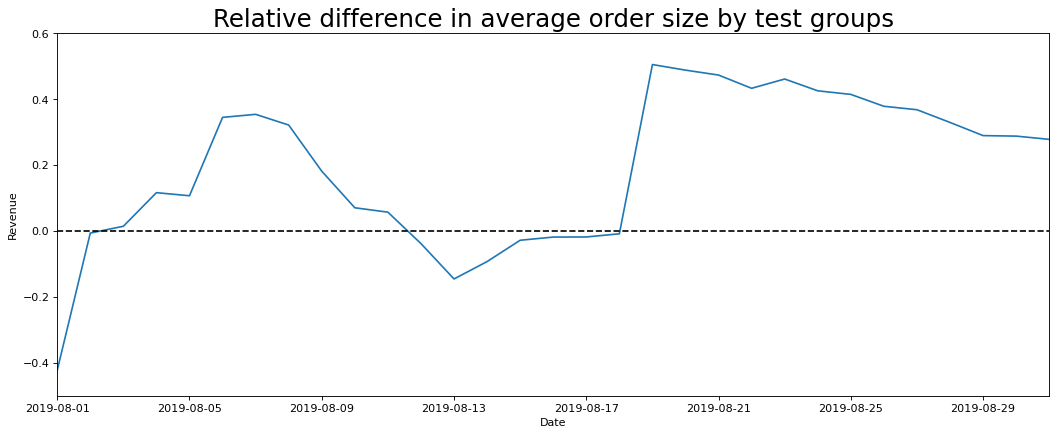

In [26]:
plt.figure(figsize=(16,6), dpi=80)
plt.plot(cum_revenue['date'],
         (cum_revenue['total_revenueB']/cum_revenue['n_ordersB']) / (cum_revenue['total_revenueA']/cum_revenue['n_ordersA'])-1)

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title("Relative difference in average order size by test groups", fontsize=22)
plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.6]) 
plt.show()

So what we see here?  
After the start of the test group B gave higher results, but then something happened in the middle which then resulted in much bigger difference. Are these results valid in this situation? Lets go further.

[back to contents](#contents)

#### CONVERSION BY GROUPS <a class="anchor" id="section_3_4"></a>

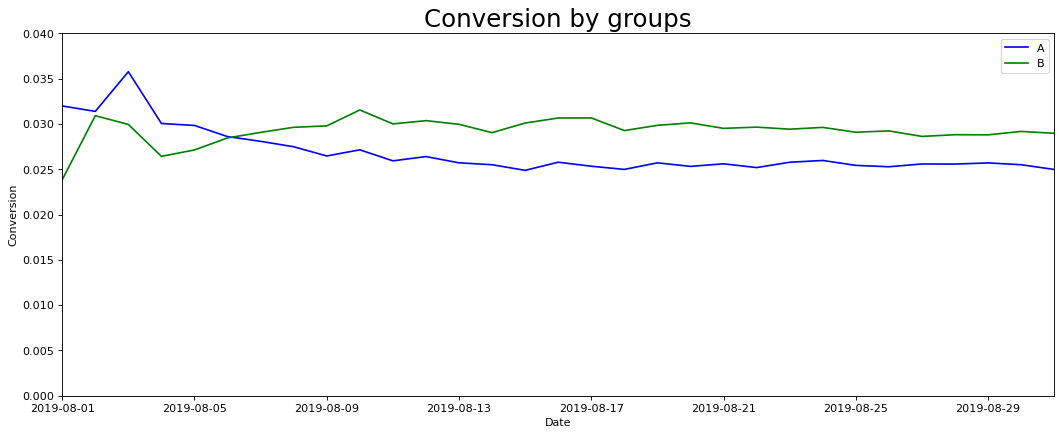

In [27]:
cumulative['conversion'] = cumulative['n_orders'] / cumulative['n_visits']
cumulativeA = cumulative[cumulative['group']=='A']
cumulativeB = cumulative[cumulative['group']=='B']

plt.figure(figsize=(16,6), dpi=80)
plt.plot(cumulativeA['date'], cumulativeA['conversion'], label = 'A', color='blue')
plt.plot(cumulativeB['date'], cumulativeB['conversion'], label = 'B', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Conversion')
plt.title("Conversion by groups", fontsize=22)
#plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', 0, 0.04]) 
plt.show()

Conversion comparison shows the **steady 'success' of group B**, as it crossed 'the border' in the 6-7th of the August it went up and remained higher all along the test. Basing on this I may assume that the experiment goes well.

[back to contents](#contents)

#### NUMBER OF ORDERS PER USER <a class="anchor" id="section_3_5"></a>

In [28]:
orders_by_users = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_users.columns=['visitorId', 'n_orders']
orders_by_users.sort_values(by='n_orders', ascending=False).head()

,visitorId,n_orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


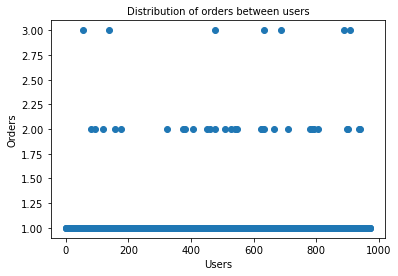

In [29]:
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['n_orders'])
plt.xlabel('Users')
plt.ylabel('Orders')
plt.title("Distribution of orders between users", fontsize=10)
plt.show()

In [30]:
np.percentile(orders_by_users['n_orders'], [95, 99])

array([1., 2.])

The scatter plot shows that **the biggest part of users made just 1 order**.  
The anomaly starts after 2 orders - about 1% of users made 3 orders, so they are outliers and could be excluded ftom the analysis.

[back to contents](#contents)

#### ORDER PRICES <a class="anchor" id="section_3_6"></a>

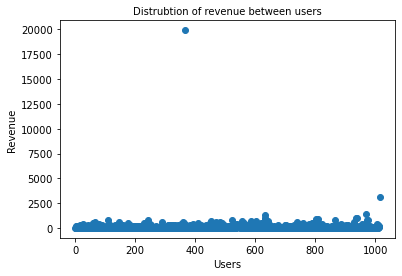

In [31]:
x_values1 = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values1, orders['revenue'])
plt.xlabel('Users')
plt.ylabel('Revenue')
plt.title("Distrubtion of revenue between users", fontsize=10)
plt.show()

In [32]:
np.percentile(orders['revenue'], [95, 99])

array([414.275, 830.3  ])

In [33]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B
1196,3936777065,2108080724,2019-08-15,3120.1,B
1136,666610489,1307669133,2019-08-13,1425.8,A
744,3668308183,888512513,2019-08-27,1335.6,B
743,3603576309,4133034833,2019-08-09,1050.0,A
1103,1348774318,1164614297,2019-08-12,1025.8,A
1099,316924019,148427295,2019-08-12,1015.9,A
949,1347999392,887908475,2019-08-21,930.0,A
940,2420050534,4003628586,2019-08-08,905.8,B
613,4071177889,3931967268,2019-08-07,830.3,B


There are several extreme values, the biggest is around 20 000. **1%** of users made purchases **more expensive than 830**. Others can be excluded from the analysis.

[back to contents](#contents)

#### STATISTICAL DIFFERENCE: RAW DATA <a class="anchor" id="section_3_7"></a>

Conversion:
- Ho: there is no difference in conversion between groups A and B
- H1: there is a difference on conversion between groups A and B

In [34]:
orders_by_usersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_usersA.columns=['visitorId', 'n_orders']
orders_by_usersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_usersB.columns=['visitorId', 'n_orders']

In [35]:
sampleA = pd.concat([orders_by_usersA['n_orders'],
                     pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum()-len(orders_by_usersA['n_orders'])), name='orders')], axis=0)

In [36]:
sampleB = pd.concat([orders_by_usersB['n_orders'],
                     pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum()-len(orders_by_usersB['n_orders'])), name='orders')], axis=0)

In [37]:
print("P-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) 
print("Relative difference: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value: 0.00551
Relative difference: 0.160


In [38]:
if (stats.mannwhitneyu(sampleA, sampleB)[1] < .05):
    print("Rejecting the null hypothesis: there is a significant difference in conversion")
else:
    print("Failed to reject the null hypothesis: there is no difference in conversion")

Rejecting the null hypothesis: there is a significant difference in conversion


On the raw data (with outliers) we found out that **there is a significant difference in conversion rates between groups A and B**. And the difference is about **16%**.

Average order size:
- Ho: there is no difference in average order size between groups A and B
- H1: there is a difference in average order size between groups A and B

In [39]:
print("P-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Relative difference: {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.431
Relative difference: 0.278


In [40]:
if (stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < .05):
    print("Rejecting the null hypothesis: there is a significant difference in average order size")
else:
    print("Failed to reject the null hypothesis: there is no difference in average order size")

Failed to reject the null hypothesis: there is no difference in average order size


We accept the null hypothesis, however, the relative difference which is quite big shows that there could be outliers affecting the final result. We will check this further on filtered data.

[back to contents](#contents)

#### STATISTICAL DIFFERENCE: FILTERED DATA <a class="anchor" id="section_3_8"></a>

Conversion:
- Ho: there is no difference in conversion between groups A and B
- H1: there is a difference on conversion between groups A and B

In [41]:
#creating filtered dataset
userswithmanyorders = pd.concat([orders_by_usersA[orders_by_usersA['n_orders'] > 2]['visitorId'],
                                 orders_by_usersB[orders_by_usersB['n_orders'] > 2]['visitorId']], axis=0)
userswithexpensiveorders = orders[orders['revenue'] > 831]['visitorId']
abnormalusers=pd.concat([userswithmanyorders, userswithexpensiveorders], axis=0).drop_duplicates().sort_values()

In [42]:
sampleA_filtered = pd.concat([orders_by_usersA[np.logical_not(orders_by_usersA['visitorId'].isin(abnormalusers))]['n_orders'],
                     pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum()-len(orders_by_usersA['n_orders'])), name='orders')], axis=0)

In [43]:
sampleB_filtered = pd.concat([orders_by_usersB[np.logical_not(orders_by_usersB['visitorId'].isin(abnormalusers))]['n_orders'],
                     pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum()-len(orders_by_usersB['n_orders'])), name='orders')], axis=0)

In [44]:
print("P-value: {0:.5f}".format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1])) 
print("Relative difference: {0:.3f}".format(sampleB_filtered.mean()/sampleA_filtered.mean()-1))

P-value: 0.00351
Relative difference: 0.189


In [45]:
if (stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1] < .05):
    print("Rejecting the null hypothesis: there is a significant difference in conversion")
else:
    print("Failed to reject the null hypothesis: there is no difference in conversion")

Rejecting the null hypothesis: there is a significant difference in conversion


Still there is significant difference in conversions, however, now it is more precise as soon as there are outliers with excessive number of orders are excluded. So the relative difference went even bigger -it is now almost **19%** (comparing to 16% earlier)

Average order size:
- Ho: there is no difference in average order size between groups A and B
- H1: there is a difference in average order size between groups A and B

In [46]:
print("P-value: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'])[1]))

print("Relative difference: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'].mean() - 1))

P-value: 0.411
Relative difference: -0.032


In [47]:
if (stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalusers)))]['revenue'])[1] < .05):
    print("Rejecting the null hypothesis: there is a significant difference in average order size")
else:
    print("Failed to reject the null hypothesis: there is no difference in average order size")

Failed to reject the null hypothesis: there is no difference in average order size


Speaking of average order size, filtering data helped us to prove that there is no actual difference between groups. It is less than **0.5%**. 

[back to contents](#contents)

### Conclusions <a class="anchor" id="chapter4"></a>

PART 1. 
I have investigated several hypotheses with ICE and RICE methods of evaluation.  
I found out that **placing the subscription form on the main page** is the best one to continue (basing on both evaluation methods).  
  
PART 2.  
**Group B** gives the better result right from the beginning: higher cumulative revenue, higher conversion. However, there were some fluctuations after the first week of the test, the second half of the moment demonstrates how better the performance of the broup B is.  
As we found out that there was no significant difference in average order size, but the conversion is higher for group B, which also leads to bigger cumulative figures.  
Basing on these results I would suggest **stopping the test, considering that group B is leading, and the test leaded to the improvement of conversion**.